(HiggsstrahlungRecooilGoodnessOfFit)=
# Events that fake the Higgsstrahlung signal

In [6]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lcio_checks.mc.simulation import add_simulation_info
from lcio_checks.rp.split_off_z import HiggsLike
from lcio_checks.util import config
from lcio_checks.util import load_or_make


def masses_heatmap(m_pair, m_recoil, bins=20, bin_range=[[0, 300], [0, 300]], ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    ax.hist2d(m_pair, m_recoil, range=bin_range, bins=bins)
    ax.set_xlabel("pair mass [GeV]")
    ax.set_ylabel("recoil mass [GeV]")
    return ax


def chi2_fct(z, h):
    return (z - 91) ** 2 / 10**2 + (h - 125) ** 2 / (
        5**2 * (h < 125) + 20**2 * (h > 125)
    )


f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
rc = f.arrays(filter_name="rc*")

higgs_like = HiggsLike(rc)
has_pair = higgs_like.has_pair
higgs_like.apply_chi2(chi2_fct)
f_reco = 100 * ak.sum(has_pair) / len(has_pair)
print(f"Fraction of events with e+e- pair reconstructed: {f_reco:.1f}%.")

Fraction of events with e+e- pair reconstructed: 69.0%.


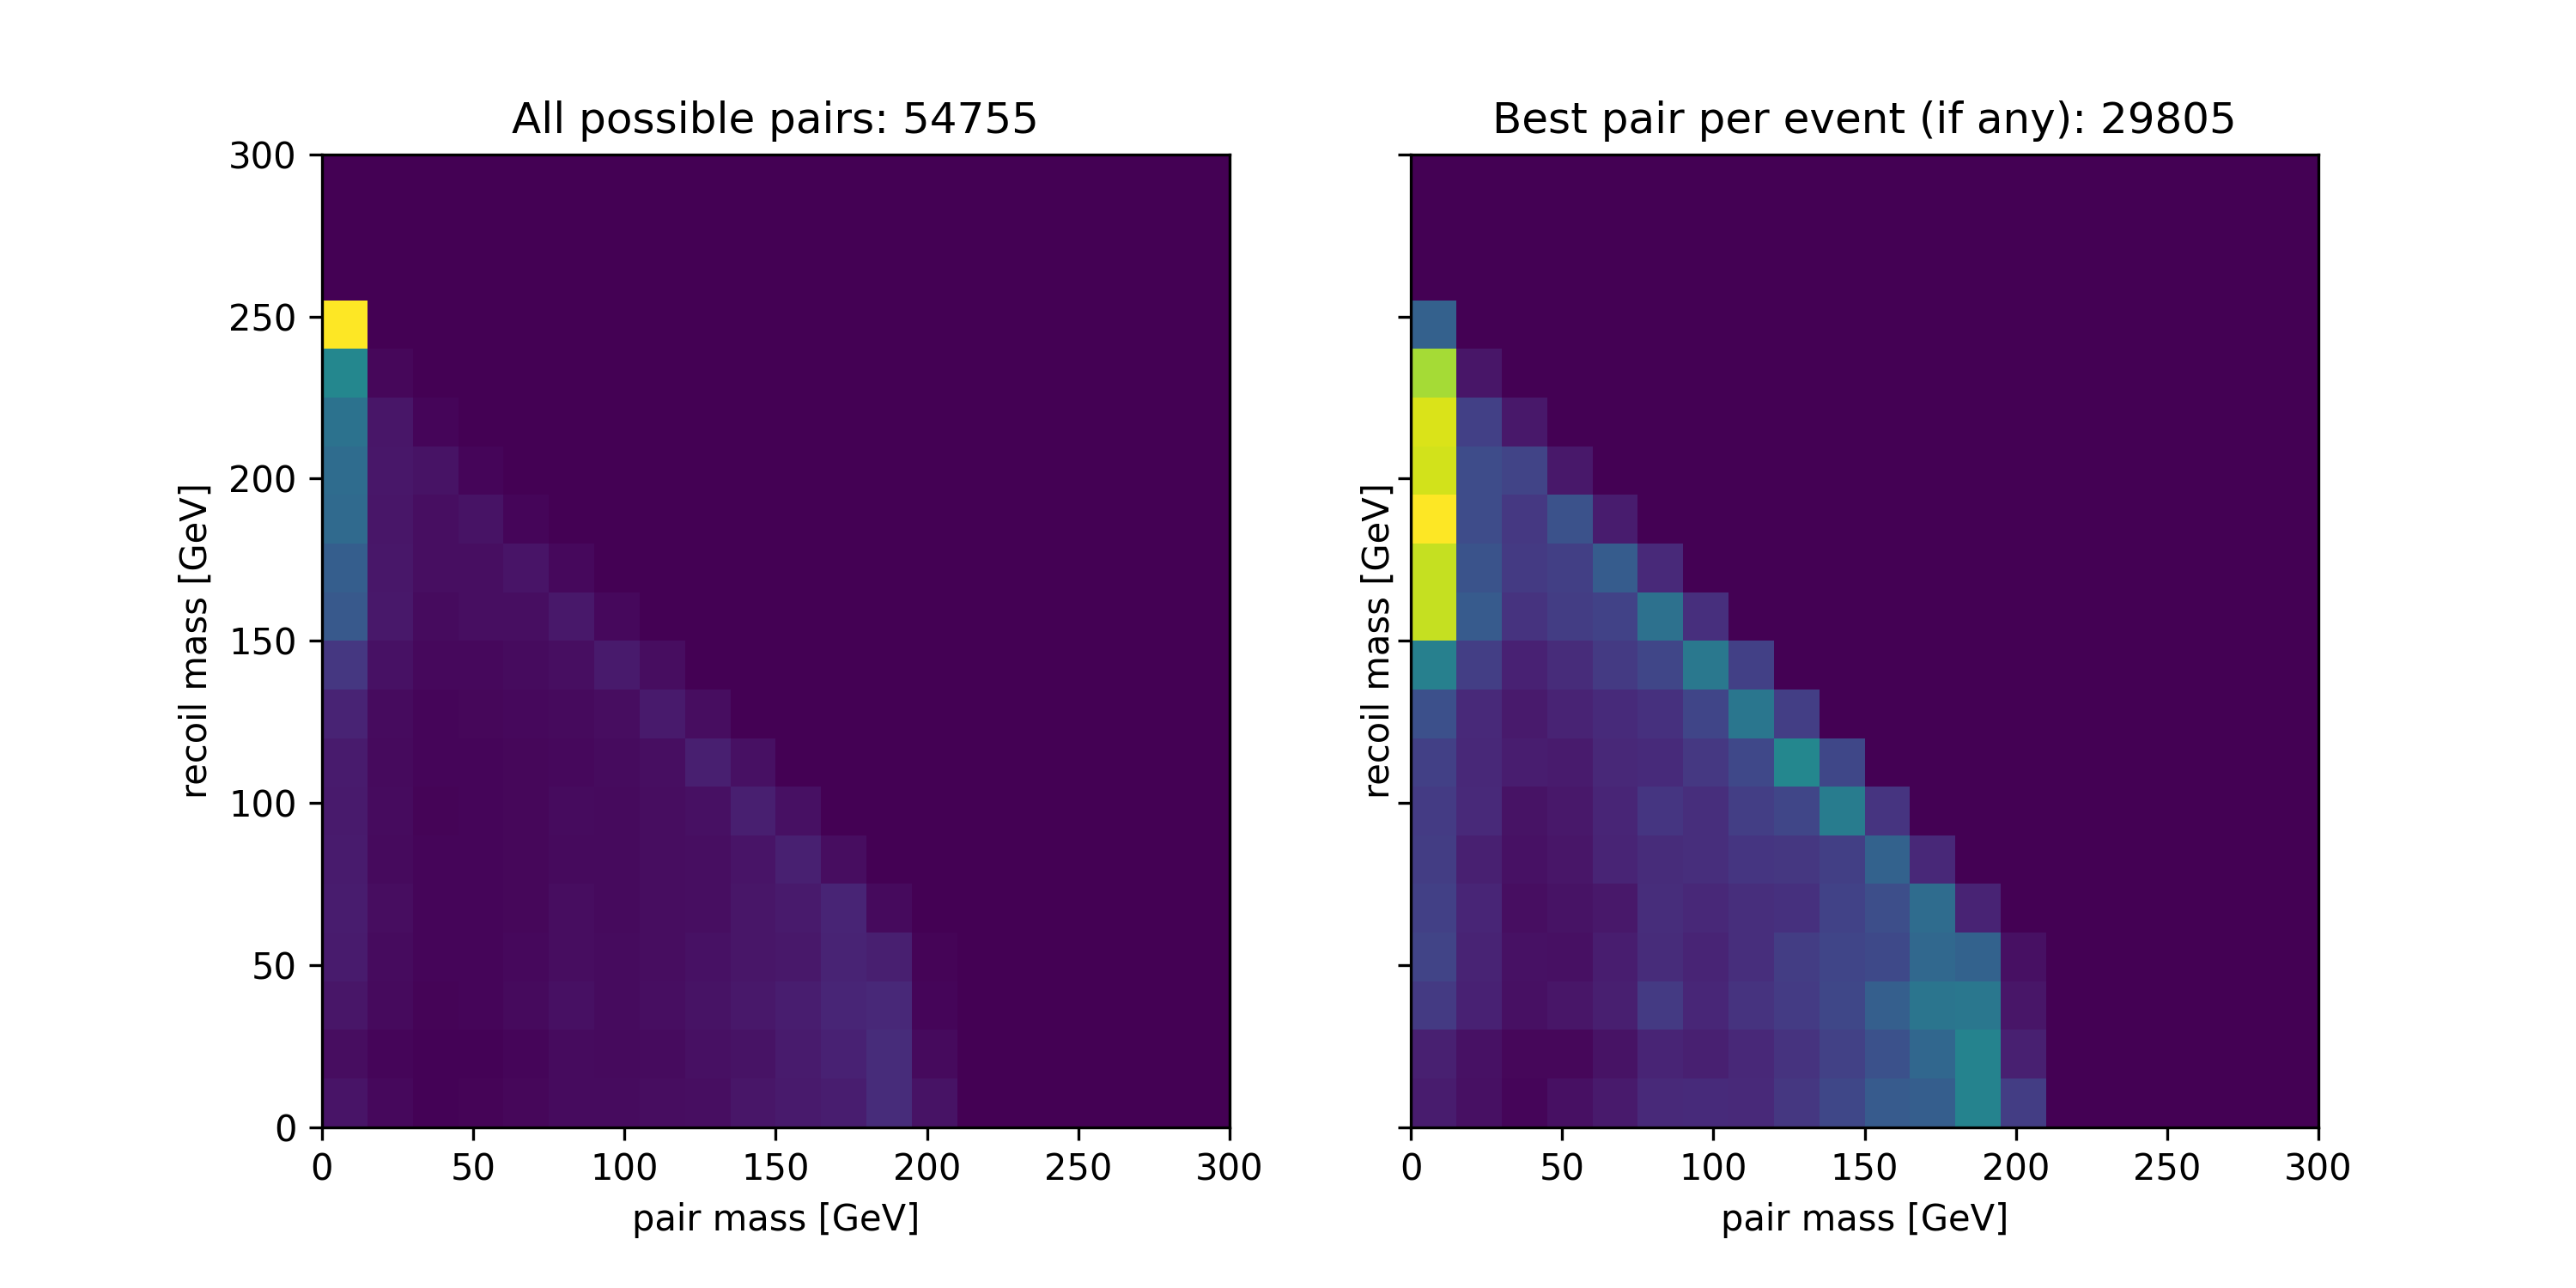

In [7]:
def mass_pair_vs_recoil_all_pairs(higgs_like, ax=None):
    m_pair = ak.flatten(higgs_like.m_pair_all)
    m_recoil = ak.flatten(higgs_like.m_recoil_all)
    ax = masses_heatmap(m_pair, m_recoil, ax=ax)
    ax.set_title(f"All possible pairs: {len(m_pair)}")
    return (ax.get_figure(),)


def mass_pair_vs_recoil_best_pair(higgs_like, ax=None):
    best_chi2 = ak.argmin(higgs_like.chi2, keepdims=True, axis=1)
    m_pair = ak.flatten(higgs_like.m_pair_all[best_chi2][has_pair])
    m_recoil = ak.flatten(higgs_like.m_recoil_all[best_chi2][has_pair])
    ax = masses_heatmap(m_pair, m_recoil, ax=ax)
    ax.set_title(f"Best pair per event (if any): {len(m_pair)}")
    return (ax.get_figure(),)


@load_or_make(["mass_pair_vs_recoil"])
def mass_pair_vs_recoil(higgs_like):
    fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True, sharey=True)
    mass_pair_vs_recoil_all_pairs(higgs_like, axs[0])
    mass_pair_vs_recoil_best_pair(higgs_like, axs[1])
    return (fig,)


mass_pair_vs_recoil(higgs_like);

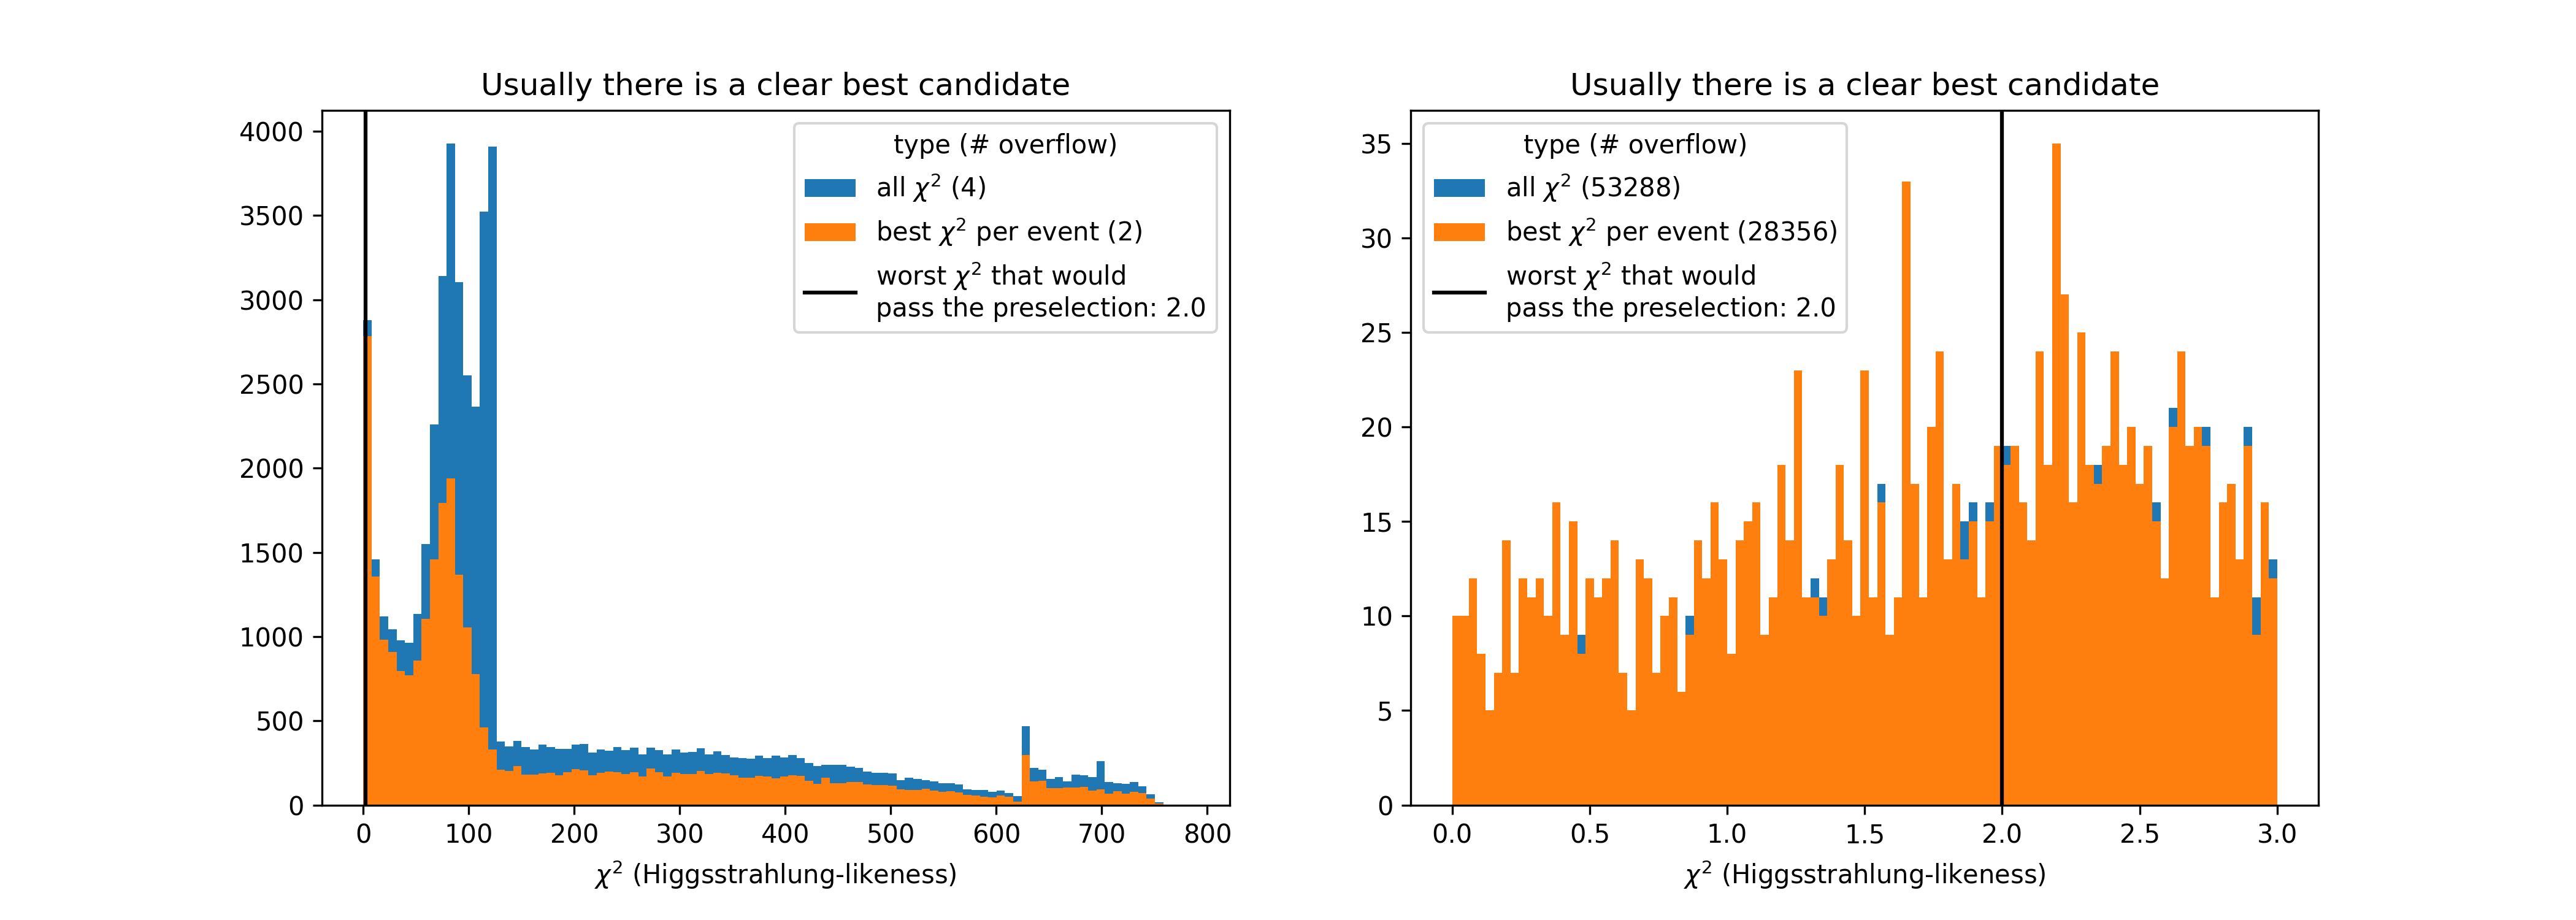

In [8]:
def chi2_distribution(higgs_like, chi2_cutoff, worst_presel, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    bins = np.linspace(0, chi2_cutoff, 100)
    chi2 = ak.flatten(higgs_like.chi2)
    best_chi2 = ak.min(higgs_like.chi2, axis=1)[ak.num(higgs_like.chi2) > 0].to_numpy()
    ax.hist(chi2, bins=bins, label=rf"all $\chi^2$ ({ak.sum(chi2 > chi2_cutoff)})")
    ax.hist(
        best_chi2,
        bins=bins,
        label=rf"best $\chi^2$ per event ({ak.sum(best_chi2 > chi2_cutoff)})",
    )
    ax.axvline(
        worst_presel,
        label=f"worst $\\chi^2$ that would\npass the preselection: {worst_presel:.1f}",
        color="black",
    )
    ax.set_title("Usually there is a clear best candidate")
    ax.set_xlabel(r"$\chi^2$ (Higgsstrahlung-likeness)")
    ax.legend(title="type (# overflow)")
    return ax


@load_or_make(["chi2_with_zoom"])
def chi2_with_zoom(higgs_like):
    worst_presel = max(
        chi2_fct(np.tile([91 - 10, 91 + 10], 2), np.repeat([125 - 5, 125 + 20], 2))
    )
    long_range = np.percentile(ak.flatten(higgs_like.chi2), 99.9) * 1.05
    cutoffs = [long_range, 1.5 * worst_presel]
    fig, axs = plt.subplots(figsize=(14, 5), ncols=len(cutoffs))
    axs = axs.flatten()
    for i, chi2_cutoff in enumerate(cutoffs):
        chi2_distribution(higgs_like, chi2_cutoff, worst_presel, ax=axs[i])
    return (fig,)


chi2_with_zoom(higgs_like);

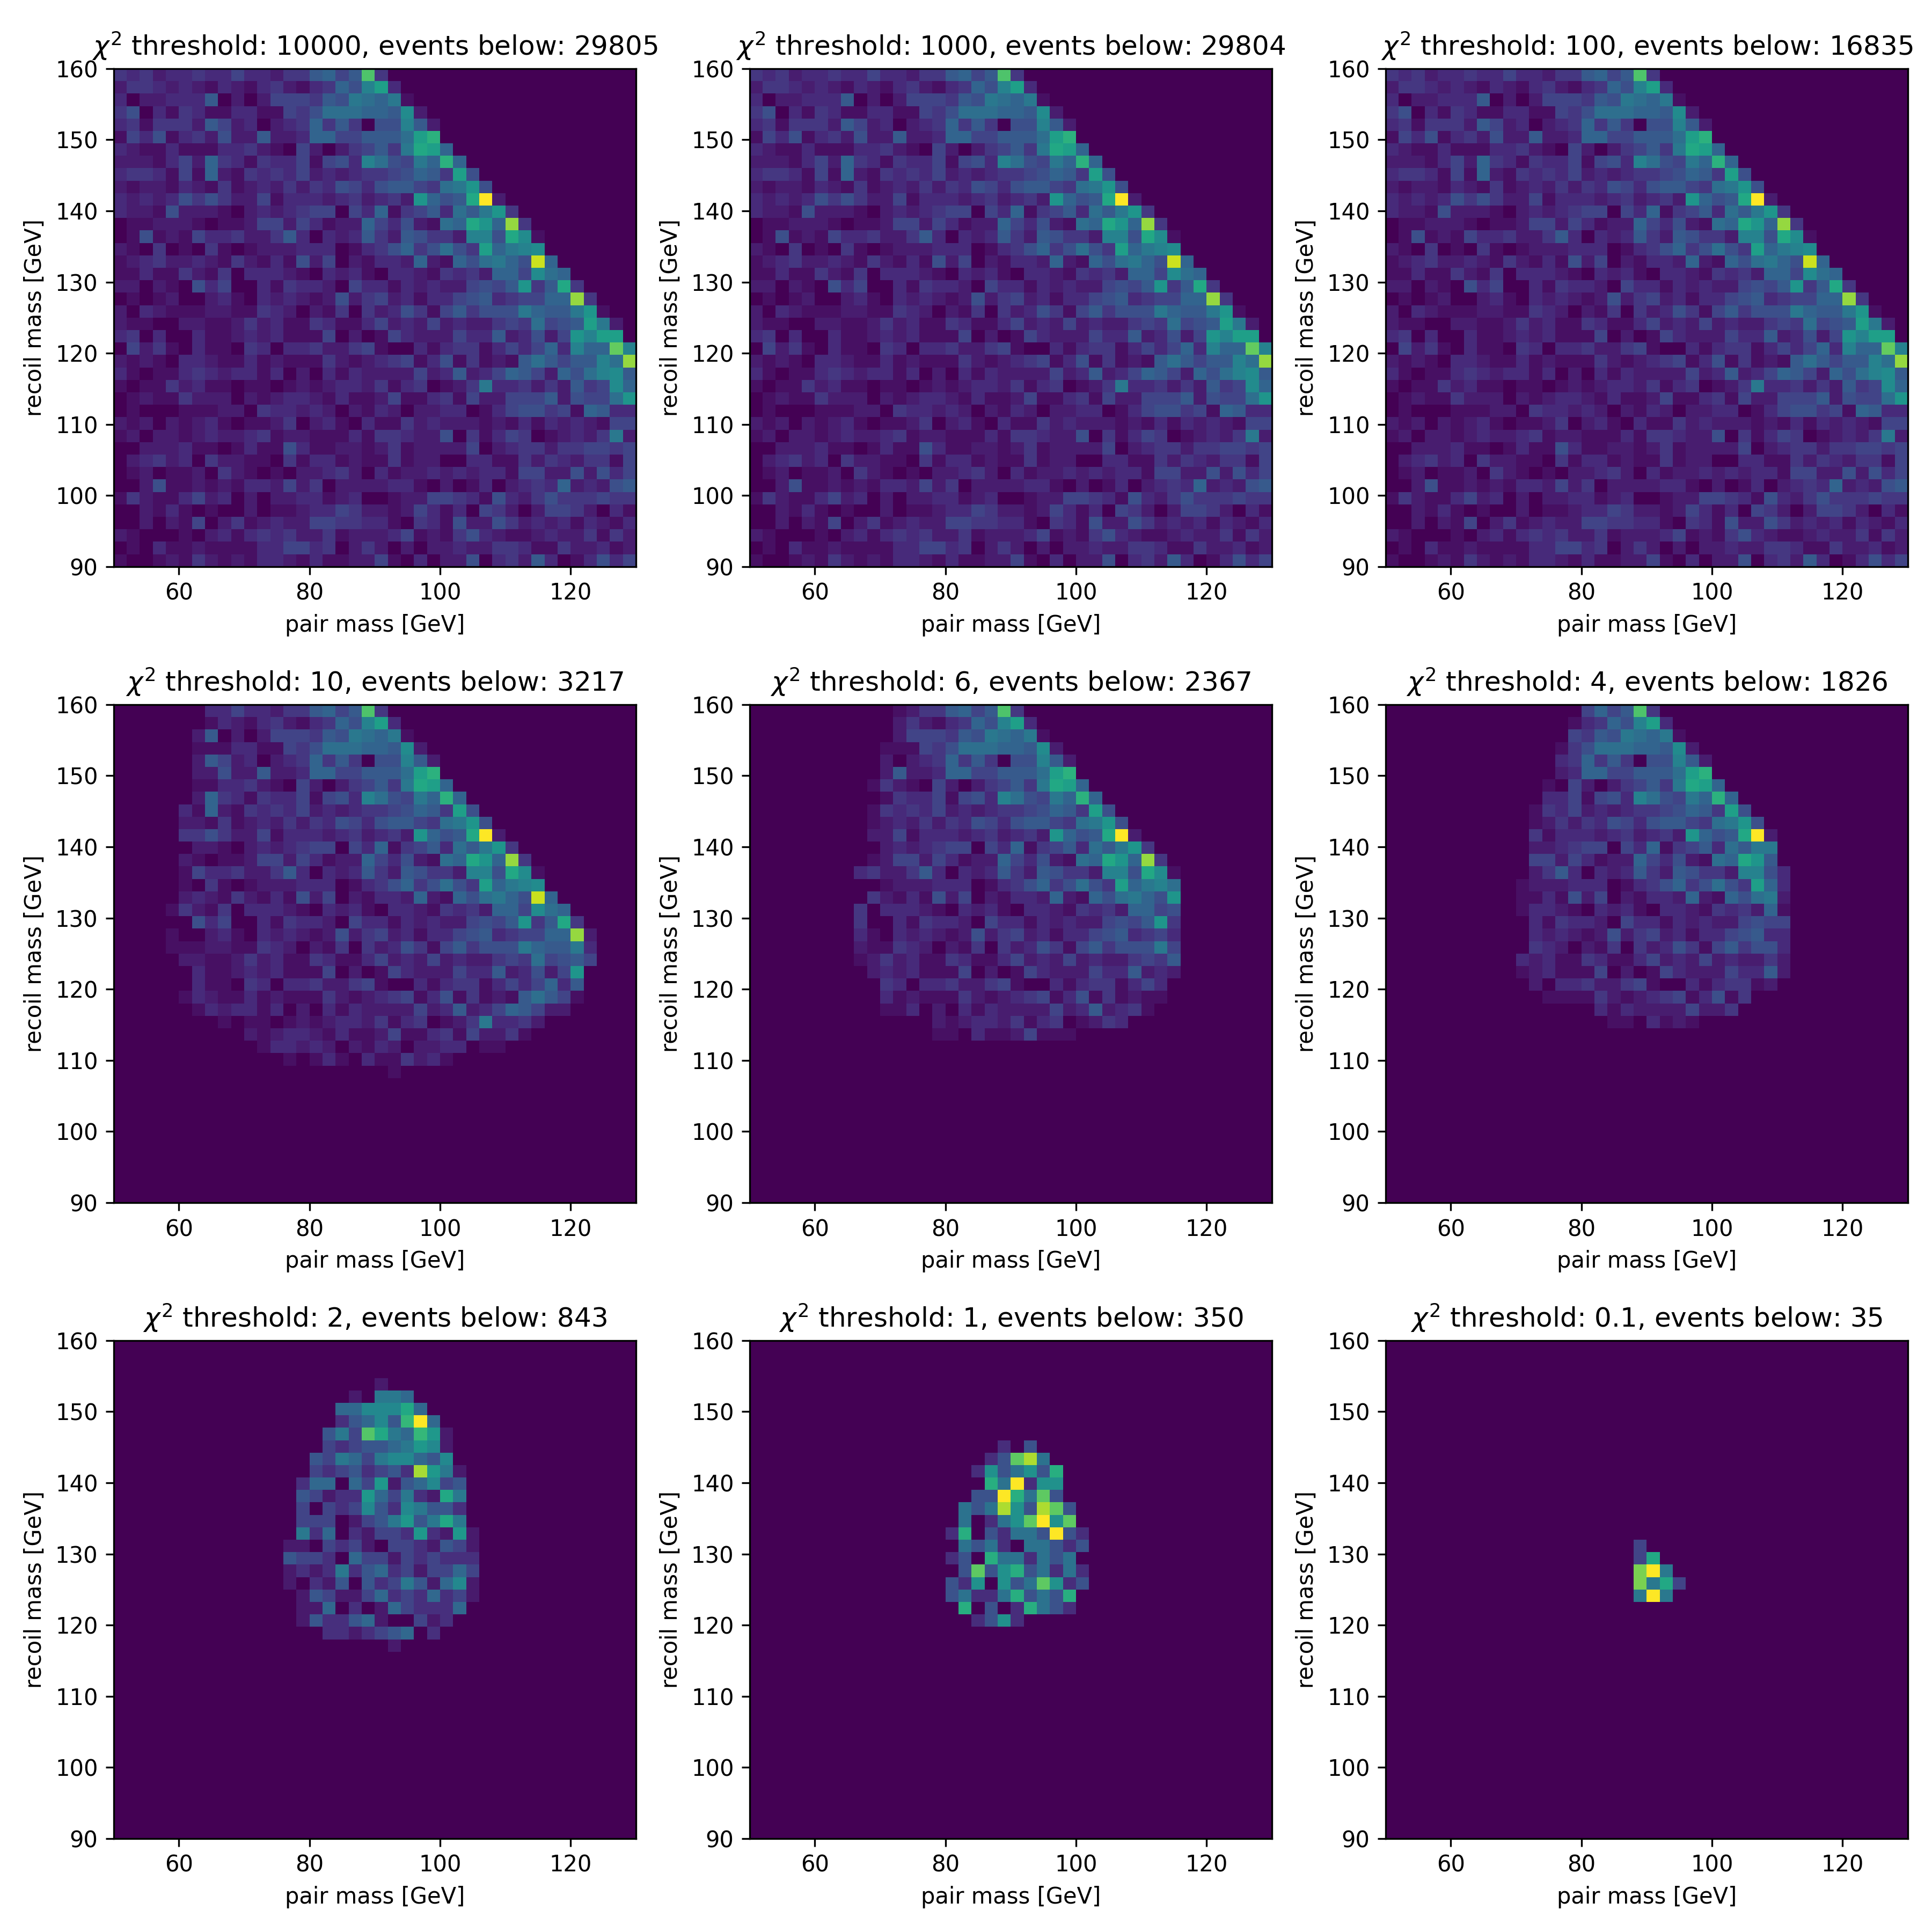

In [9]:
@load_or_make(["masses_heatmap_increase_chi2"])
def masses_heatmap_increase_chi2(higgs_like):
    id_best_chi2 = ak.argmin(higgs_like.chi2, keepdims=True, axis=1)
    m_pair = ak.flatten(higgs_like.m_pair_all[id_best_chi2][has_pair])
    m_recoil = ak.flatten(higgs_like.m_recoil_all[id_best_chi2][has_pair])
    best_chi2 = ak.flatten(higgs_like.chi2[id_best_chi2][has_pair])

    thresholds = [0.1, 1, 2, 4, 6, 10, 100, 1000, 10000][::-1]
    nrows = (len(thresholds) + 1) // 3
    fig, axs = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 4 * nrows))
    for chi2_threshold, ax in zip(thresholds, axs.flatten()):
        mask = best_chi2 < chi2_threshold
        ax = masses_heatmap(
            m_pair[mask],
            m_recoil[mask],
            ax=ax,
            bin_range=[[50, 130], [90, 160]],
            bins=40,
        )
        ax.set_title(
            rf"$\chi^2$ threshold: {chi2_threshold}, events below: {sum(mask)}"
        )
    fig.tight_layout()
    return (fig,)


masses_heatmap_increase_chi2(higgs_like);

## Why can a Bhabha fake a Higgststrahlung event?

In the long tails, there will be some electrons/positrons that are drastically different from the kinematic state that is assumed in the recoil mass calculation: 
$(P_{e^+_{in}} + P_{e^-_{in}})^2 = (s, 0, 0, 0)$.

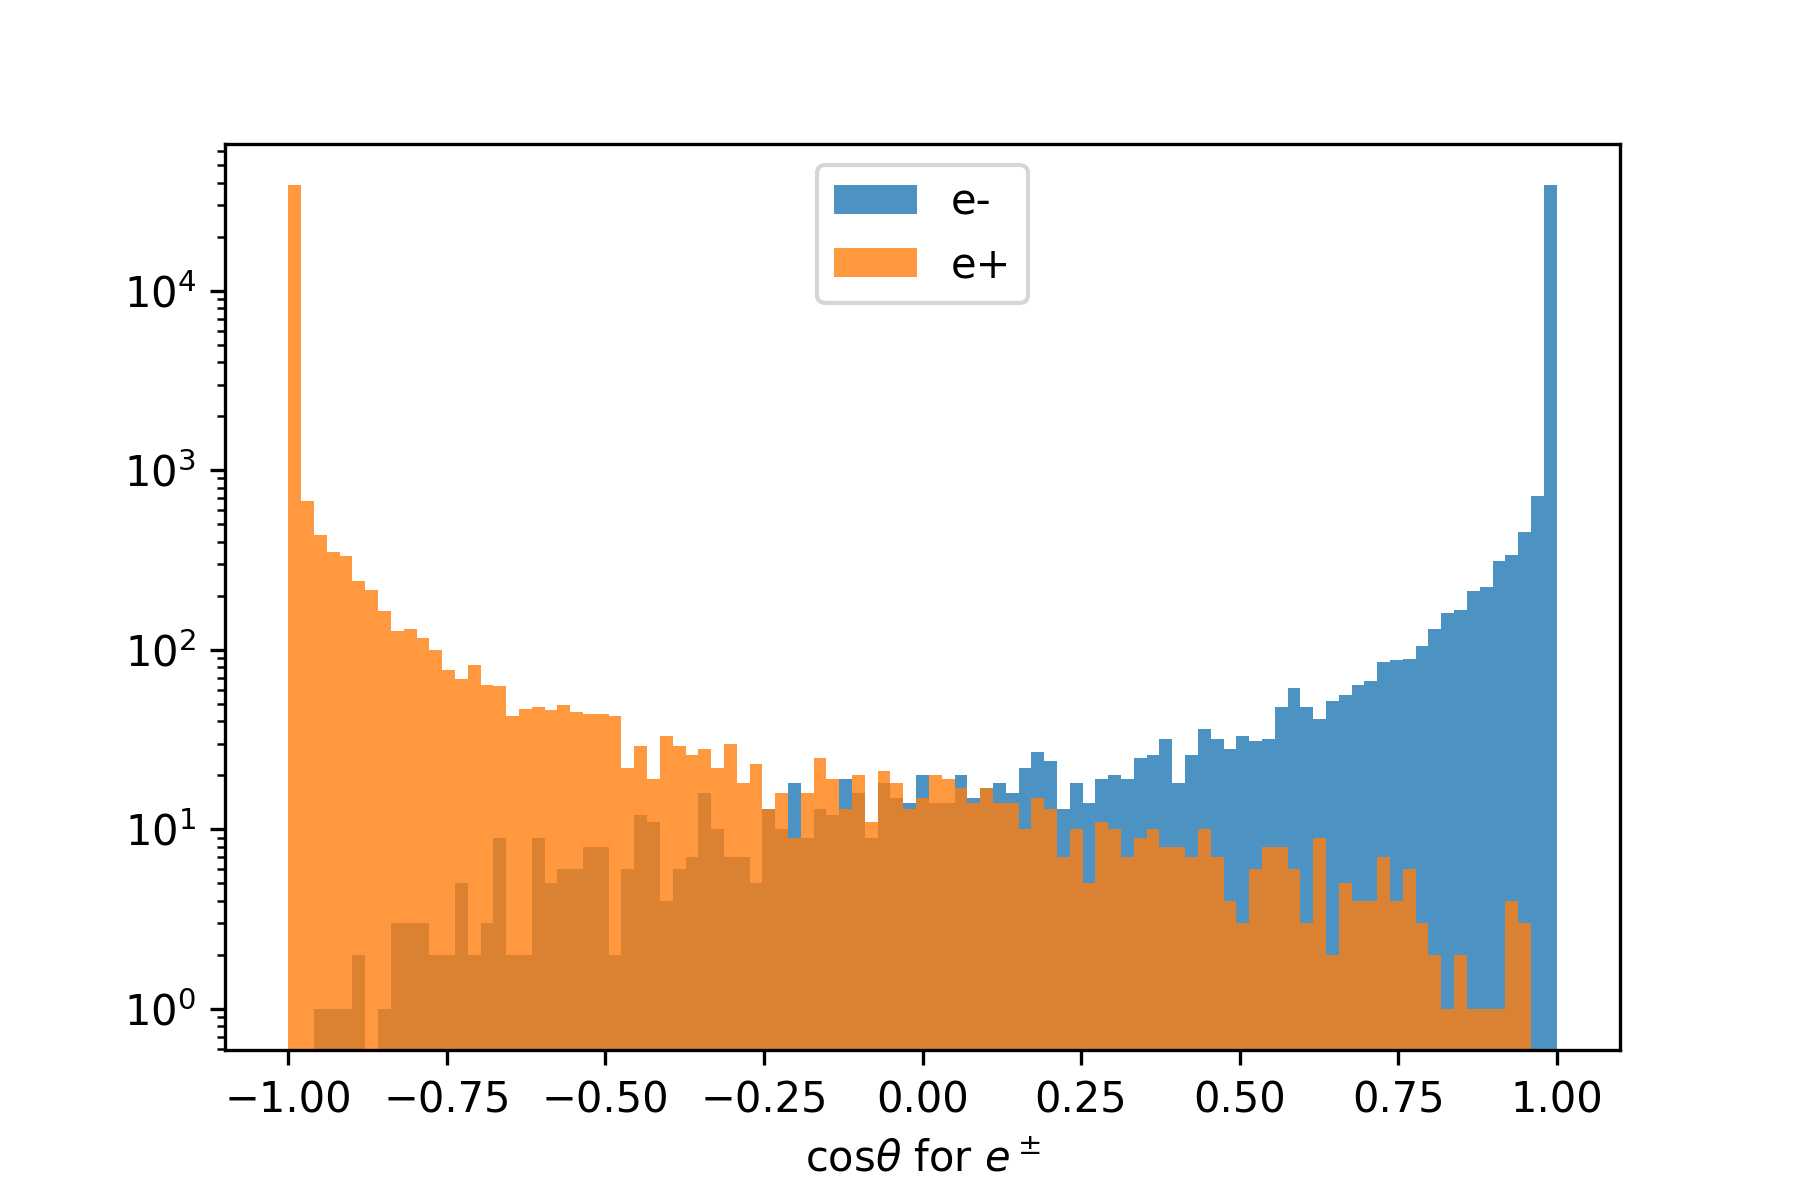

In [10]:
@load_or_make(["bhabha_angle_e_pm_mc"])
def bhabha_angle_e_pm_mc(f):
    mc = f.arrays(filter_name="mc*", entry_stop=-1)
    add_simulation_info(mc)
    mem = mc[(mc.mcgst == 3) & ~mc.isOverlay]
    fig, ax = plt.subplots()
    plt.hist(
        (mem.mcmoz / mem.mcene)[mem.mcpdg == 11],
        bins=np.linspace(-1, 1, 100),
        alpha=0.8,
        label="e-",
    )
    plt.hist(
        (mem.mcmoz / mem.mcene)[mem.mcpdg == -11],
        bins=np.linspace(-1, 1, 100),
        alpha=0.8,
        label="e+",
    )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("cos$\\theta$ for $e^\\pm$")
    return (fig,)


bhabha_angle_e_pm_mc(f);